Load the necessary modules and setup the volume estimation parameters.

In [98]:
import numpy as np
import pandas as pd
import scipy
import cv2
import keras.backend as K
from pyntcloud import PyntCloud
from sklearn import linear_model
import matplotlib.pyplot as plt
from inference.project import *

# Inputs (https://rgbd-dataset.cs.washington.edu/index.html)
input_img = cv2.imread('custom/apple.png', cv2.IMREAD_COLOR)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) / 255
depth = cv2.imread('custom/apple_depth.png', cv2.IMREAD_UNCHANGED) / 1000
# Intrinsics
intrinsics = np.array([[570.3, 0, 320], [0, 570.3, 240], [0, 0, 1]])
intrinsics_inv = np.linalg.inv(intrinsics)

Convert the input image and depth map to a 3D point cloud.

In [99]:
# Depth map to point cloud
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
points = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))

# Create point cloud dataframe
points = np.reshape(points, points.shape[1:]) # Ignore batch size
#points[:,:,0] *= -1 # Invert x axis
#points[:,:,2] *= -1 # Invert z axis
points = np.reshape(points, (points.shape[0]*points.shape[1], 3)) # Reshape to (m*n,3)
colors = np.reshape(input_img, (input_img.shape[0]*input_img.shape[1], 3)) * 255 # Reshape to (m*n,3)
points_df = pd.DataFrame(np.concatenate((points, colors), axis=-1), 
                         columns=['x','y','z','red','green','blue'])

Plot the loaded inputs and the created point cloud.

<IPython.core.display.Javascript object>


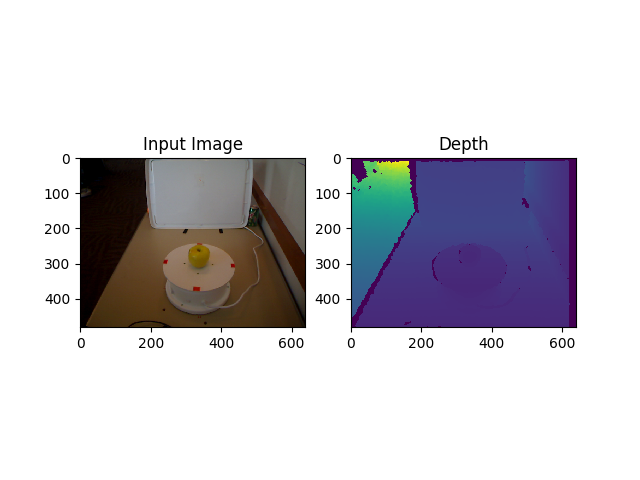

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.15102135713331186, 0.5235307991271236, 10…

In [100]:
# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Input Image')
plt.imshow(input_img)
plt.subplot(122)
plt.title('Depth')
plt.imshow(depth)
plt.show()

# Plot point cloud
point_cloud = PyntCloud(points_df)
point_cloud.plot(initial_point_size=0.001)

Use the segmentation mask to seperate object points from input image.

<IPython.core.display.Javascript object>


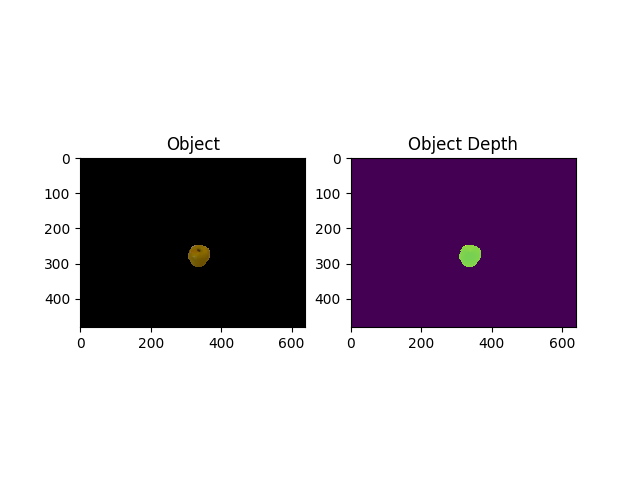

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.020235985290290713, 0.13416344533927754, 1…

In [111]:
# Generate masked object point cloud
object_mask = cv2.imread('custom/apple_mask_2.png', cv2.IMREAD_GRAYSCALE) / 255
object_img = np.tile(np.expand_dims(object_mask, -1), (1,1,3)) * input_img
object_depth = object_mask * depth
object_depth_tensor = K.variable(np.expand_dims(object_depth, 0))
object_points = K.eval(get_cloud(object_depth_tensor, intrinsics_inv_tensor))

object_points = np.reshape(object_points, object_points.shape[1:]) # Ignore batch size
#object_points[:,:,0] *= -1 # Invert x axis
#object_points[:,:,2] *= -1 # Invert z axis
object_points = np.reshape(object_points, (object_points.shape[0]*object_points.shape[1], 3))
# Ignore points with depth=0 (unmasked)
depth_filter = np.reshape(object_depth, (object_depth.shape[0]*object_depth.shape[1])) > 0
object_points = object_points[depth_filter, :]
object_colors = np.reshape(object_img, (object_img.shape[0]*object_img.shape[1], 3)) * 255 # Reshape to (m*n,3)
object_colors = object_colors[depth_filter, :]
object_points_df = pd.DataFrame(np.concatenate((object_points, object_colors), axis=-1), 
                                columns=['x','y','z','red','green','blue'])

# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Object')
plt.imshow(object_img)
plt.subplot(122)
plt.title('Object Depth')
plt.imshow(object_depth)
plt.show()

# Plot point cloud
object_point_cloud = PyntCloud(object_points_df)
object_point_cloud.plot(initial_point_size=0.001)

Use the plate mask to find the surface on which the object is placed on.

<IPython.core.display.Javascript object>


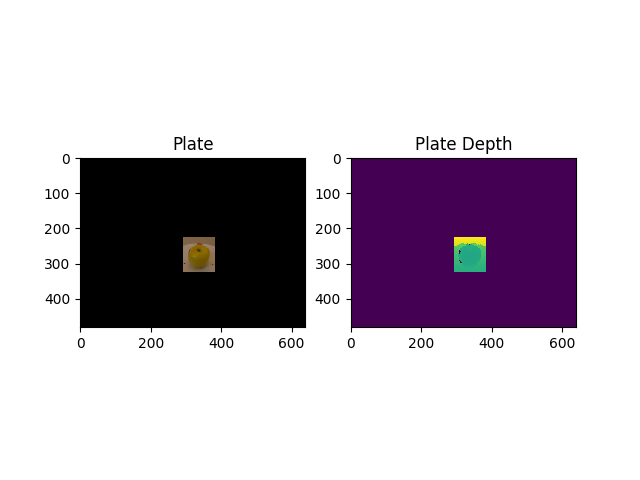

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.023302736836145872, 0.14986044839840568, 2…

In [112]:
# Generate masked plate point cloud
plate_mask = cv2.imread('custom/plate_mask.png', cv2.IMREAD_GRAYSCALE) / 255
plate_img = np.tile(np.expand_dims(plate_mask, -1), (1,1,3)) * input_img
plate_depth = plate_mask * depth
plate_depth_tensor = K.variable(np.expand_dims(plate_depth, 0))
plate_points = K.eval(get_cloud(plate_depth_tensor, intrinsics_inv_tensor))

plate_points = np.reshape(plate_points, plate_points.shape[1:]) # Ignore batch size
#plate_points[:,:,0] *= -1 # Invert x axis
#plate_points[:,:,2] *= -1 # Invert z axis
plate_points = np.reshape(plate_points, (plate_points.shape[0]*plate_points.shape[1], 3))
# Ignore points with depth=0 (unmasked)
depth_filter = np.reshape(plate_depth, (plate_depth.shape[0]*plate_depth.shape[1])) > 0
plate_points = plate_points[depth_filter, :]
plate_colors = np.reshape(plate_img, (plate_img.shape[0]*plate_img.shape[1], 3)) * 255 # Reshape to (m*n,3)
plate_colors = plate_colors[depth_filter, :]
plate_points_df = pd.DataFrame(np.concatenate((plate_points, plate_colors), axis=-1), 
                                columns=['x','y','z','red','green','blue'])

# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Plate')
plt.imshow(plate_img)
plt.subplot(122)
plt.title('Plate Depth')
plt.imshow(plate_depth)
plt.show()

# Plot point cloud
plate_point_cloud = PyntCloud(plate_points_df)
plate_point_cloud.plot(initial_point_size=0.001)

Use RANSAC algorithm to estimate the plate surface.

In [113]:
# Use mean k-nearest neighbors distance to determine RANSAC max fitting distance
kdtree = scipy.spatial.cKDTree(plate_points)
k = 10
distances, _ = kdtree.query(plate_points, k)
mean_distances = np.mean(distances[:, 1:])
# Apply ransac algorithm on plate points
ransac = linear_model.RANSACRegressor(residual_threshold=mean_distances)
ransac.fit(plate_points[:,:2], plate_points[:,2:])
inlier_mask = ransac.inlier_mask_.astype(int)
coeffs = ransac.estimator_.intercept_.tolist() + ransac.estimator_.coef_[0].tolist()
print('Surface coefficients (w0,w1,w2):', coeffs)

# Plot plate surface and object point cloud
surface_points = np.concatenate((plate_points[:,:2], ransac.predict(plate_points[:,:2])), axis=-1)
surface_points_df = pd.DataFrame(surface_points, columns=['x','y','z'])
surface_point_cloud = PyntCloud(surface_points_df)
scene = object_point_cloud.plot(initial_point_size=0.001, return_scene=True)
surface_point_cloud.plot(initial_point_size=0.01, use_as_color='z', cmap='cool', scene=scene)

Surface coefficients (w0,w1,w2): [0.8727521896362305, -0.009744960814714432, -1.4287291765213013]


/home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.020235985290290713, 0.13416344533927754, 1…

Compute distance of each object point to plane. Triangulate the points on the xy plane and compute volume by trapezoidal integration using as z the computed distance.

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.018779774867619087, -0.15270899475018063, …

Total Volume: 0.5210499209504669 L


<IPython.core.display.Javascript object>


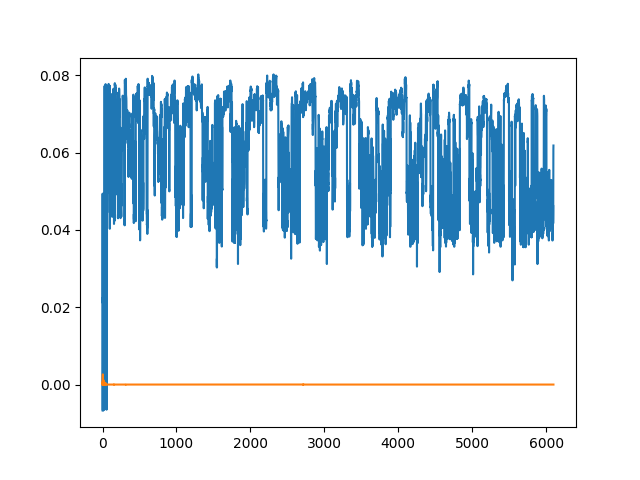

<IPython.core.display.Javascript object>


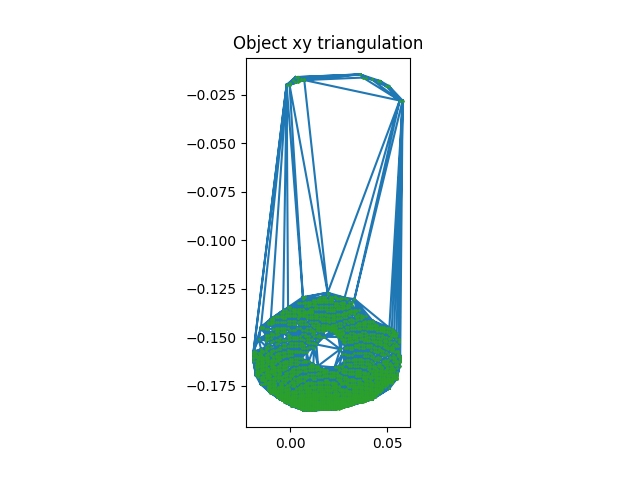

In [114]:
# Transform points to align plane normal with z-axis
plane_normal = np.array([coeffs[1], coeffs[2], -1]) / np.sqrt(coeffs[1]**2 + coeffs[2]**2 + 1)
translation = -np.array([0, 0, coeffs[0]])
axis = np.cross(plane_normal, np.array([0, 0, 1])) # Rotation axis
axis /= np.sqrt(np.sum(axis*axis)) # Normalize
angle = np.arccos(plane_normal[2])
r = scipy.spatial.transform.Rotation.from_rotvec(angle * axis)
rotation_matrix = r.as_dcm()
# Transform
object_points_transformed = np.dot(object_points + translation, rotation_matrix.T)
surface_points_transformed = np.dot(surface_points + translation, rotation_matrix.T)

# Project points on surface and use as xy plane
#distance_to_plane = ((coeffs[1]*object_points[:,0] + coeffs[2]*object_points[:,1] - object_points[:,2] + coeffs[0])
#                     / np.sqrt(coeffs[1]**2 + coeffs[2]**2 + 1))
#print(distance_to_plane)
#print(object_points_transformed[:,2])
#print(surface_points_transformed[:,2])

# Plot point clouds of transformed object
transformed_points_df = pd.DataFrame(object_points_transformed, columns=['x','y','z'])
transformed_point_cloud = PyntCloud(transformed_points_df)
scene = transformed_point_cloud.plot(initial_point_size=0.001, use_as_color='z', return_scene=True)
# Transformed surface
transformed_surface_points_df = pd.DataFrame(surface_points_transformed, columns=['x','y','z'])
transformed_surface_point_cloud = PyntCloud(transformed_surface_points_df)
transformed_surface_point_cloud.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

# Calculate volume
volume_points = object_points_transformed
tri = scipy.spatial.Delaunay(volume_points[:,:2])
tri_vertices = volume_points[tri.simplices, :]
side_a = tri_vertices[:,1,:2] - tri_vertices[:,0,:2]
side_b = tri_vertices[:,2,:2] - tri_vertices[:,0,:2]
area = 0.5 * np.abs(np.cross(side_a, side_b, axis=1))
mean_height = np.mean(tri_vertices[:,:,2], axis=-1)
volumes = area * mean_height
total_volume = np.abs(np.sum(volumes))
print('Total Volume:', total_volume * 1000, 'L')



%matplotlib notebook
plt.figure()
plt.plot(mean_height)
plt.plot(area)

plt.figure()
plt.triplot(volume_points[:,0], volume_points[:,1], tri.simplices.copy())
plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Object xy triangulation')
plt.show()
